# DSCI 552 Project - Dhwanil Shah, 1889110444, DhwanilHShah

In [1]:
import pandas as pd
import os
import random
import math
import shutil
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, activations, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
%matplotlib inline

## Data Preprocessing

### Species to Class Mapping

In [2]:
df = pd.read_excel("../data/Classes.xlsx", names=['Folder', 'Class'])
name_to_class_dict = dict(zip(df.Folder, df.Class))
class_to_name_dict = dict(zip(df.Class, df.Folder))

### Split Train, Validation, Test Data

In [3]:
original_dir = "../data/images"
base_dir = "../data/images_split"

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [4]:
for species_class in df['Folder']:
  train_class_dir = os.path.join(train_dir, species_class)
  os.makedirs(train_class_dir, exist_ok=True)

  validation_class_dir = os.path.join(validation_dir, species_class)
  os.makedirs(validation_class_dir, exist_ok=True)
    
  test_class_dir = os.path.join(test_dir, species_class)
  os.makedirs(test_class_dir, exist_ok=True)
    
  original_class_dir = os.path.join(original_dir, species_class)
  
  images = os.listdir(original_class_dir)
  n_images = len(images)

  for image in random.sample(images, math.ceil(0.7*n_images)):
    shutil.copyfile(os.path.join(original_class_dir, image), 
                    os.path.join(train_class_dir, image))
    images.remove(image)

  for image in random.sample(images, math.ceil(0.15*n_images)):
    shutil.copyfile(os.path.join(original_class_dir, image), 
                    os.path.join(validation_class_dir, image))
    images.remove(image)

  for image in images:
    shutil.copyfile(os.path.join(original_class_dir, image), 
                    os.path.join(test_class_dir, image))

### Hyper Parameters

In [5]:
n_classes=20
batch_size = 10
width = 224
height = 224
epochs = 50
NUM_TRAIN = sum([len(files) for r, d, files in os.walk(train_dir)])
NUM_TEST = sum([len(files) for r, d, files in os.walk(validation_dir)])
dropout_rate = 0.2
input_shape = (height, width, 3)

### Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(
      # rescale=1./255,
      rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
      # fill_mode='nearest'
      )


test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1173 images belonging to 20 classes.
Found 658 images belonging to 20 classes.
Found 624 images belonging to 20 classes.


## Transfer Learning : EfficientNetB0

### Model

In [7]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, 
                            input_shape=input_shape, classes=n_classes)
base_model.trainable = False

2022-12-11 16:16:09.546338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model = models.Sequential()
model.add(base_model)
model.add(BatchNormalization(name="Batch_Normalization"))
model.add(layers.Activation(activations.relu, name="relu_layer"))
model.add(layers.GlobalMaxPooling2D(name="GlobalMaxPooling"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate))
# model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
model.add(layers.Dense(n_classes, activation='softmax', name="softmax_output"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 Batch_Normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 relu_layer (Activation)     (None, 7, 7, 1280)        0         
                                                                 
 GlobalMaxPooling (GlobalMax  (None, 1280)             0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 softmax_output (Dense)      (None, 20)                2

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      workers=4,
      callbacks=[early_stopping])

Epoch 1/50
117/117 [==============================] - 28s 212ms/step - loss: 6.0483 - accuracy: 0.3207 - val_loss: 1.1670 - val_accuracy: 0.7631
Epoch 2/50
117/117 [==============================] - 24s 204ms/step - loss: 2.2326 - accuracy: 0.6724 - val_loss: 0.6891 - val_accuracy: 0.8677
Epoch 3/50
117/117 [==============================] - 24s 205ms/step - loss: 1.7006 - accuracy: 0.7300 - val_loss: 0.5133 - val_accuracy: 0.9154
Epoch 4/50
117/117 [==============================] - 24s 204ms/step - loss: 1.2971 - accuracy: 0.7859 - val_loss: 0.4435 - val_accuracy: 0.9215
Epoch 5/50
117/117 [==============================] - 24s 205ms/step - loss: 1.4036 - accuracy: 0.7893 - val_loss: 0.2540 - val_accuracy: 0.9615
Epoch 6/50
117/117 [==============================] - 24s 205ms/step - loss: 1.1763 - accuracy: 0.8100 - val_loss: 0.2145 - val_accuracy: 0.9646
Epoch 7/50
117/117 [==============================] - 24s 207ms/step - loss: 1.1550 - accuracy: 0.8194 - val_loss: 0.2820 - val_ac

### Training and Validation Errors vs Epochs Plot

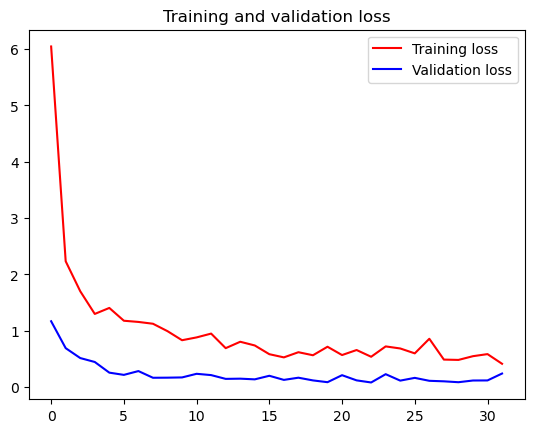

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [11]:
test_generator.batch_size = test_generator.samples
y_true = np.argmax(next(test_generator)[1], axis=1)

In [12]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

1/1 [==============================] - 17s 17s/step


In [13]:
print("Test Accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("Precision: {}".format(precision_score(y_true, y_pred, average="macro")))
print("Recall: {}".format(recall_score(y_true, y_pred, average="macro")))
print("F1 score: {}".format(f1_score(y_true, y_pred, average="macro")))

Test Accuracy: 0.9711538461538461
Precision: 0.9726278004834039
Recall: 0.9708588791467644
F1 score: 0.9701190374636027


## Transfer Learning : VGG16

### Model

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, 
                            input_shape=input_shape, classes=n_classes)
base_model.trainable = False

In [15]:
model = models.Sequential()
model.add(base_model)
model.add(BatchNormalization(name="Batch_Normalization"))
model.add(layers.Activation(activations.relu, name="relu_layer"))
model.add(layers.GlobalMaxPooling2D(name="GlobalMaxPooling"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate))
# model.add(BatchNormalization(momentum=0.95, epsilon=0.005))
model.add(layers.Dense(n_classes, activation='softmax', name="softmax_output"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 Batch_Normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 relu_layer (Activation)     (None, 7, 7, 512)         0         
                                                                 
 GlobalMaxPooling (GlobalMax  (None, 512)              0         
 Pooling2D)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 softmax_output (Dense)      (None, 20)               

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      workers=4,
      callbacks=[early_stopping])

Epoch 1/50
117/117 [==============================] - 270s 2s/step - loss: 8.5893 - accuracy: 0.0903 - val_loss: 5.2638 - val_accuracy: 0.2677
Epoch 2/50
117/117 [==============================] - 267s 2s/step - loss: 5.5105 - accuracy: 0.2253 - val_loss: 2.6909 - val_accuracy: 0.4708
Epoch 3/50
117/117 [==============================] - 267s 2s/step - loss: 4.1203 - accuracy: 0.3405 - val_loss: 1.7618 - val_accuracy: 0.6015
Epoch 4/50
117/117 [==============================] - 267s 2s/step - loss: 3.4186 - accuracy: 0.4093 - val_loss: 1.2391 - val_accuracy: 0.6754
Epoch 5/50
117/117 [==============================] - 267s 2s/step - loss: 2.9427 - accuracy: 0.4609 - val_loss: 0.9507 - val_accuracy: 0.7354
Epoch 6/50
117/117 [==============================] - 267s 2s/step - loss: 2.5622 - accuracy: 0.5176 - val_loss: 0.8549 - val_accuracy: 0.7646
Epoch 7/50
117/117 [==============================] - 266s 2s/step - loss: 2.4831 - accuracy: 0.5271 - val_loss: 0.7130 - val_accuracy: 0.8031

### Training and Validation Errors vs Epochs Plot

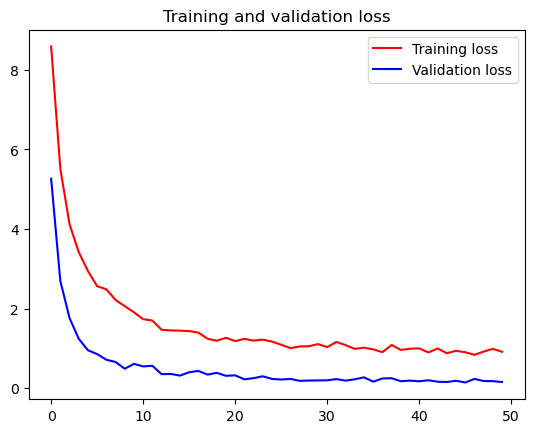

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Prediction

In [18]:
test_generator.batch_size = test_generator.samples
y_true = np.argmax(next(test_generator)[1], axis=1)

In [19]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

1/1 [==============================] - 104s 104s/step


In [20]:
print("Test Accuracy: {}".format(accuracy_score(y_true, y_pred)))
print("Precision: {}".format(precision_score(y_true, y_pred, average="macro")))
print("Recall: {}".format(recall_score(y_true, y_pred, average="macro")))
print("F1 score: {}".format(f1_score(y_true, y_pred, average="macro")))

Test Accuracy: 0.9310897435897436
Precision: 0.9319119715227588
Recall: 0.9320681135357368
F1 score: 0.9305365320999499
